In [90]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import *

In [91]:
df = pd.read_csv("./DATA/Emotions/emotions.csv")

In [92]:
num_columns = len(df.columns)
print(len(df.index), num_columns)

2132 2549


In [93]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def Oversample(data, labels):
    zeros = []
    ones = []
    for (index, label) in enumerate(labels):
        if label == 0:
            zeros.append(data[index])
        else:
            ones.append(data[index])

    zeros, ones = np.array(zeros), np.array(ones)
    ids = np.arange(len(ones))
    choices = np.random.choice(ids, len(zeros)) #choose entries from so that number of ones and zeroes are the same 

    res_ones_features = ones[choices]
    res_ones_labels = np.ones(len(res_ones_features))

    resampled_features = np.concatenate([res_ones_features, zeros], axis=0)
    resampled_labels = np.concatenate([res_ones_labels, np.zeros(len(zeros))], axis=0)

    return unison_shuffled_copies(resampled_features, resampled_labels)
        

In [94]:
df.head() #each row represents one second

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


In [95]:
df = df.sample(frac=1) #shuffle dataset
data = df.drop(['label'], axis=1).to_numpy()
labels = df['label'].to_numpy()

In [96]:
all_labels = list(set(labels))
print(all_labels)
class_labels = tfds.features.ClassLabel(names=all_labels)

['POSITIVE', 'NEGATIVE', 'NEUTRAL']


In [97]:
labels = np.array([class_labels.str2int(x) for x in labels])

In [98]:
norm = np.linalg.norm(data, axis=0)
data = data/norm

In [99]:
assert(len(data) == len(labels))
train, validate, test = np.split(data, [int(.6*len(data)), int(.8*len(data))])
train_labels, validate_labels, test_labels = np.split(labels, [int(.6*len(labels)), int(.8*len(labels))])

In [100]:
print(train.shape, validate.shape, test.shape)

(1279, 2548) (426, 2548) (427, 2548)


In [101]:
TIMESTEPS = 1
def Reshape(input):
    size, features = input.shape
    return input.reshape(size, TIMESTEPS, features)
train, validate, test = Reshape(train), Reshape(validate), Reshape(test)

In [220]:
EPOCHS = 50
BATCH_SIZE = 64 #seems to be a good batch size
INPUT_SHAPE = (TIMESTEPS, num_columns-1)
DROPOUT = 0.2

In [221]:
def Model():
    input = layers.Input(shape=INPUT_SHAPE)
    cell = layers.LSTMCell(4, dropout=DROPOUT) #need dropout
    rnn = layers.RNN(cell)(input)
    fc1 = layers.Dense(64, activation='relu')(rnn)
    d1 = layers.Dropout(DROPOUT)(fc1)
    fc2 = layers.Dense(128, activation='relu')(d1)
    output = layers.Dense(3, activation='softmax')(fc2)
    model = tf.keras.Model(inputs=input, outputs=output)
    return model
model = Model()
model.summary()

Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 1, 2548)]         0         
_________________________________________________________________
rnn_17 (RNN)                 (None, 4)                 40848     
_________________________________________________________________
dense_47 (Dense)             (None, 64)                320       
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_49 (Dense)             (None, 3)                 387       
Total params: 49,875
Trainable params: 49,875
Non-trainable params: 0
_________________________________________________

In [222]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [223]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)

history = model.fit(train, train_labels, 
epochs=EPOCHS, 
validation_data=(validate, validate_labels), 
batch_size=BATCH_SIZE, 
verbose=2, 
callbacks=[callback],
# class_weight=class_weight,
shuffle=True)

Epoch 1/50
20/20 - 1s - loss: 1.0846 - accuracy: 0.6998 - val_loss: 1.0520 - val_accuracy: 0.6854
Epoch 2/50
20/20 - 0s - loss: 0.9870 - accuracy: 0.6630 - val_loss: 0.9074 - val_accuracy: 0.6831
Epoch 3/50
20/20 - 0s - loss: 0.8617 - accuracy: 0.6677 - val_loss: 0.8114 - val_accuracy: 0.7160
Epoch 4/50
20/20 - 0s - loss: 0.7888 - accuracy: 0.7709 - val_loss: 0.7479 - val_accuracy: 0.8803
Epoch 5/50
20/20 - 0s - loss: 0.7140 - accuracy: 0.8991 - val_loss: 0.6849 - val_accuracy: 0.8967
Epoch 6/50
20/20 - 0s - loss: 0.6579 - accuracy: 0.9249 - val_loss: 0.6575 - val_accuracy: 0.9038
Epoch 7/50
20/20 - 0s - loss: 0.6382 - accuracy: 0.9242 - val_loss: 0.6478 - val_accuracy: 0.9178
Epoch 8/50
20/20 - 0s - loss: 0.6296 - accuracy: 0.9281 - val_loss: 0.6386 - val_accuracy: 0.9178
Epoch 9/50
20/20 - 0s - loss: 0.6212 - accuracy: 0.9382 - val_loss: 0.6361 - val_accuracy: 0.9178
Epoch 10/50
20/20 - 0s - loss: 0.6190 - accuracy: 0.9390 - val_loss: 0.6340 - val_accuracy: 0.9249
Epoch 11/50
20/20 -

In [224]:
# model.save("./Models/Emotions_LSTM1.h5")

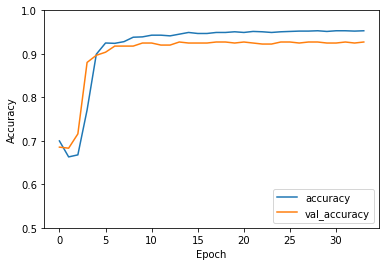

In [225]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [226]:
test_loss, test_acc = model.evaluate(test,  test_labels, verbose=2)

14/14 - 0s - loss: 0.6198 - accuracy: 0.9321


In [227]:
test_labels[:50]

array([2, 1, 0, 2, 0, 1, 0, 1, 0, 2, 1, 1, 2, 0, 2, 2, 2, 2, 2, 0, 1, 0,
       1, 0, 2, 0, 1, 0, 0, 2, 0, 1, 0, 2, 0, 0, 1, 2, 2, 2, 2, 0, 2, 1,
       0, 0, 0, 0, 2, 1])

In [228]:
# prediction = model.predict(np.expand_dims(test[0], axis=0))
prediction = model.predict(test)
print(prediction.shape)
for (index,p) in enumerate(prediction[:50]):
    # print(p)
    print(class_labels.int2str(np.argmax(p)), class_labels.int2str(test_labels[index]))
    # print(np.argmax(prediction))

(427, 3)
NEUTRAL NEUTRAL
NEGATIVE NEGATIVE
POSITIVE POSITIVE
NEUTRAL NEUTRAL
NEGATIVE POSITIVE
NEGATIVE NEGATIVE
POSITIVE POSITIVE
NEGATIVE NEGATIVE
POSITIVE POSITIVE
NEUTRAL NEUTRAL
NEGATIVE NEGATIVE
NEGATIVE NEGATIVE
NEUTRAL NEUTRAL
NEGATIVE POSITIVE
NEUTRAL NEUTRAL
NEUTRAL NEUTRAL
NEUTRAL NEUTRAL
NEUTRAL NEUTRAL
NEUTRAL NEUTRAL
POSITIVE POSITIVE
NEGATIVE NEGATIVE
POSITIVE POSITIVE
NEGATIVE NEGATIVE
POSITIVE POSITIVE
NEUTRAL NEUTRAL
NEGATIVE POSITIVE
NEGATIVE NEGATIVE
POSITIVE POSITIVE
POSITIVE POSITIVE
NEUTRAL NEUTRAL
POSITIVE POSITIVE
NEGATIVE NEGATIVE
POSITIVE POSITIVE
NEUTRAL NEUTRAL
POSITIVE POSITIVE
NEGATIVE POSITIVE
NEGATIVE NEGATIVE
NEUTRAL NEUTRAL
NEUTRAL NEUTRAL
NEUTRAL NEUTRAL
NEUTRAL NEUTRAL
POSITIVE POSITIVE
NEUTRAL NEUTRAL
NEGATIVE NEGATIVE
POSITIVE POSITIVE
POSITIVE POSITIVE
POSITIVE POSITIVE
POSITIVE POSITIVE
NEUTRAL NEUTRAL
NEGATIVE NEGATIVE
